In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optiland import optic
from optiland import optimization
from optiland.distribution import AnnularDistribution

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

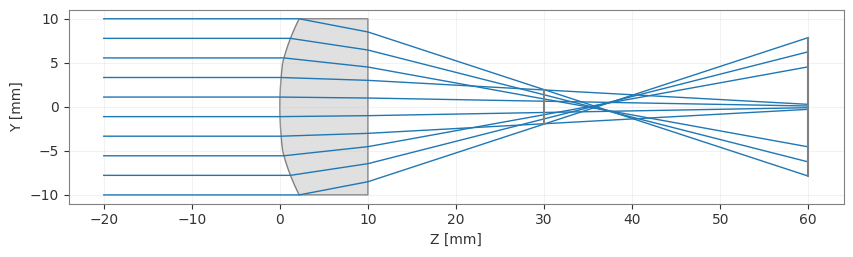

In [2]:
lens = optic.Optic()

lens.add_surface(index=0, radius = np.inf, thickness=np.inf)
lens.add_surface(
    index=1,
    thickness=10.0,
    is_stop=True,
    material = 'SF2',
    surface_type='segmented_surface',
    split_radius=5.0,
    cv1 = 40,
    cv2 = 20,
    k1 = 0,
    k2 = -1,
    a1={2: 0.0, 4: 0.0, 6: 0.0, 8: 0.0},
    a2={2: 0.0, 4: 0.0, 6: 0.0, 8: 0.0},
)
lens.add_surface(index=2, radius = np.inf, thickness=20.0)
lens.add_surface(index=3, surface_type='paraxial', f = np.inf, thickness=30.0)
lens.add_surface(index=4)

lens.set_aperture(aperture_type='EPD', value=20.0)

lens.set_field_type(field_type="angle")
lens.add_field(y=0)

lens.add_wavelength(value=0.55, is_primary=True)

lens.draw(num_rays=10)

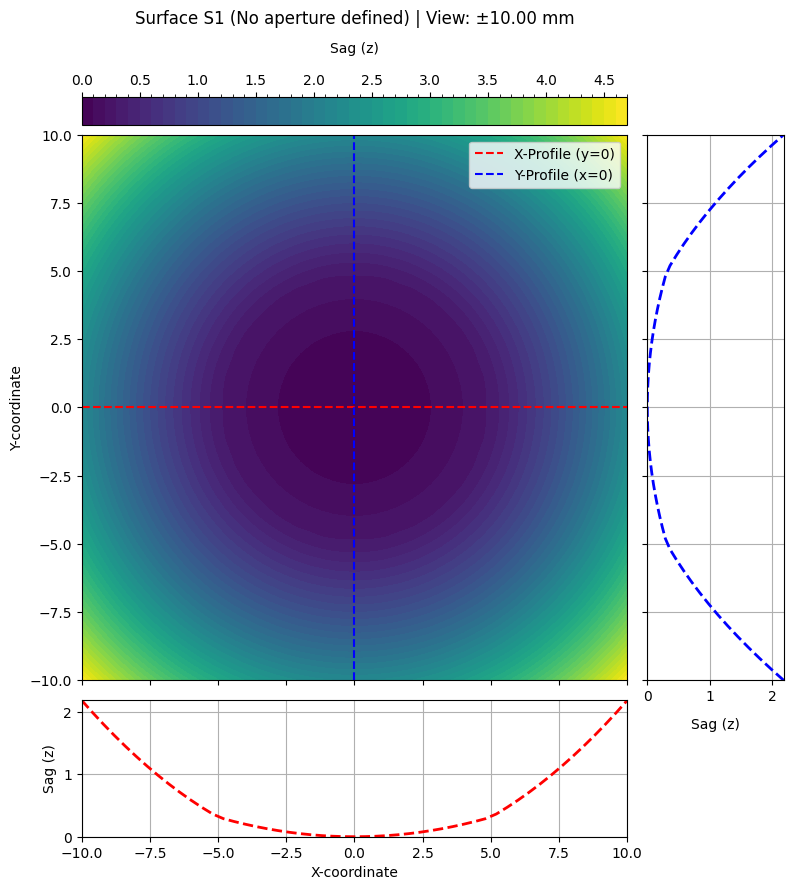

In [3]:
lens.plot_surface_sag(1, max_extent=10)

In [4]:
surface1 = lens.surface_group.surfaces[1]
split_radius = surface1.geometry.split_radius
print(split_radius)

5.0


In [5]:
lens.update_paraxial()
print("Seimidia of surface 1:", surface1.semi_aperture)
print("Semidia of surface 1:", surface1.y[-1])

ya, _ = lens.paraxial.marginal_ray()
print("Paraxial marginal ray height at surface 1:", ya[1, 0])

semidia_s1 = surface1.semi_aperture


Seimidia of surface 1: 10.0
Semidia of surface 1: 10.0
Paraxial marginal ray height at surface 1: 10.0


In [6]:
normalized_sr = split_radius / semidia_s1

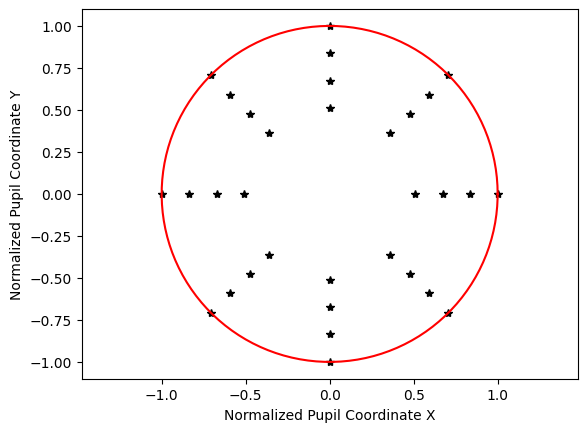

In [7]:
ring_zone = AnnularDistribution(r_inner=normalized_sr + 0.01, r_outer=1.0, num_arms = 8, num_rings=4)
ring_zone.generate_points()
fig, ax = ring_zone.view()
plt.show()

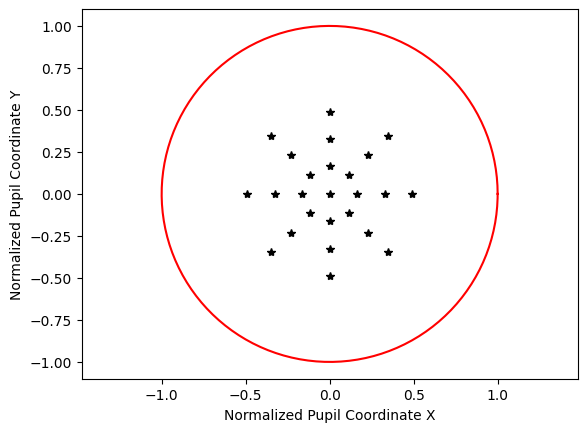

In [8]:
center_zone = AnnularDistribution(r_inner=0.0, r_outer=normalized_sr - 0.01, num_arms = 8, num_rings=4)
center_zone.generate_points()
fig, ax = center_zone.view()
plt.show()

In [13]:
problem = optimization.OptimizationProblem()

problem.add_operand(
    operand_type='rms_spot_size',
    target=0.0,
    weight=1.0,
    input_data={
        'optic': lens,
        "surface_number": -1,
        "Hx": 0.0,
        "Hy": 0.0,
        "num_rays": 5,
        'wavelength': 0.55,
        'distribution': ring_zone,
    }
)

problem.add_operand(
    operand_type='rms_spot_size',
    target=0.0,
    weight=1.0,
    input_data={
        'optic': lens,
        "surface_number": -2,
        "Hx": 0.0,
        "Hy": 0.0,
        "num_rays": 5,
        'wavelength': 0.55,
        'distribution': center_zone,
    }
)

problem.add_variable(lens, "cv1", surface_number=1, min_val=-1000.0, max_val=1000.0)
problem.add_variable(lens, "cv2", surface_number=1, min_val=-1000.0, max_val=1000.0)
problem.add_variable(lens, "k1", surface_number=1, min_val=-100.0, max_val=100.0)
problem.add_variable(lens, "k2", surface_number=1, min_val=-100.0, max_val=100.0)

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                3.48086 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.047 │   0.047 │           0.06 │
│  1 │ rms spot size  │        0 │              │              │        1 │   1.865 │   1.865 │          99.94 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤═════════════╤════════════

In [14]:
optimizer = optimization.OptimizerGeneric(problem)
optimizer.optimize()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0029264200309397337
        x: [-8.270e-01 -6.426e-01  7.987e-04 -1.211e+00]
      nit: 3
      jac: [-1.022e-02 -3.080e-01  2.382e-03 -4.292e-03]
     nfev: 75
     njev: 15
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [15]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │             0.00292642 │           99.9159 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.047 │   0.047 │          76.75 │
│  1 │ rms spot size  │        0 │              │              │        1 │   0.026 │   0.026 │          23.25 │
╘════╧════════════════╧══════════╧══════════════╧══════════════╧══════════╧═════════╧═════════╧════════════════╛
╒════╤═════════════════╤═══════════╤══════════════╤═══════════

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

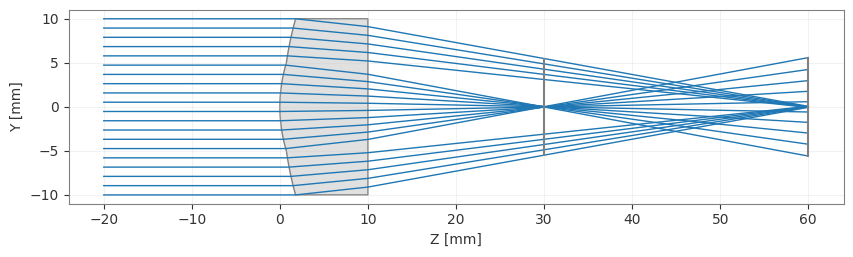

In [16]:
lens.draw(num_rays=20)